In [1]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [2]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Duwamish/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

In [3]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [4]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


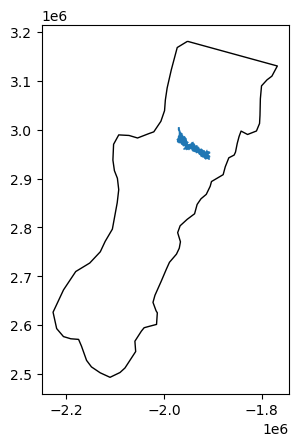

In [5]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [6]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx       -1.974567e+06
miny        2.938089e+06
maxx       -1.905108e+06
maxy        3.005395e+06
x          -1.942311e+06
y           2.965860e+06
range_x     6.945981e+04
range_y     6.730695e+04
area_km2    2.732960e+03
Name: 0, dtype: float64 minx       -2.226802e+06
miny        2.493512e+06
maxx       -1.768135e+06
maxy        3.180672e+06
x          -2.008039e+06
y           2.857019e+06
range_x     4.586673e+05
range_y     6.871599e+05
area_km2    2.486724e+05
Name: 0, dtype: float64


In [7]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [17]:
# Set simulation parameters
lam = 10                   # average number of storms per year
n_full = 10000            # number of years to simulate
n_part = 1000

# Run the simulations
df_full_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_full, method = 'uniform')
df_full_monte = get_return_period(df_full_monte)

df_part_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'uniform')
df_part_monte = get_return_period(df_part_monte)

df_part_is = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'truncnorm',dist_x = dist_x, dist_y = dist_y)
df_part_is = get_return_period(df_part_is)

100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


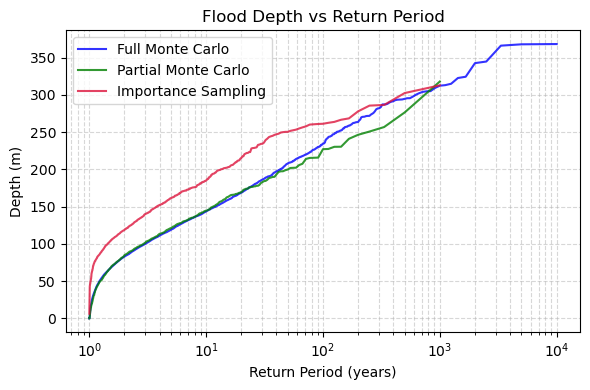

In [18]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_full_monte['return_period'], df_full_monte['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_part_monte['return_period'], df_part_monte['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_part_is['return_period'], df_part_is['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (m)')
plt.title('Flood Depth vs Return Period')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

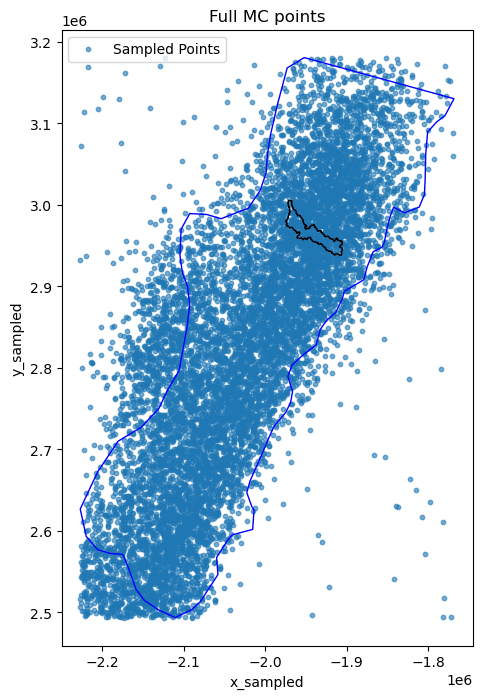

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
df_full_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Full MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

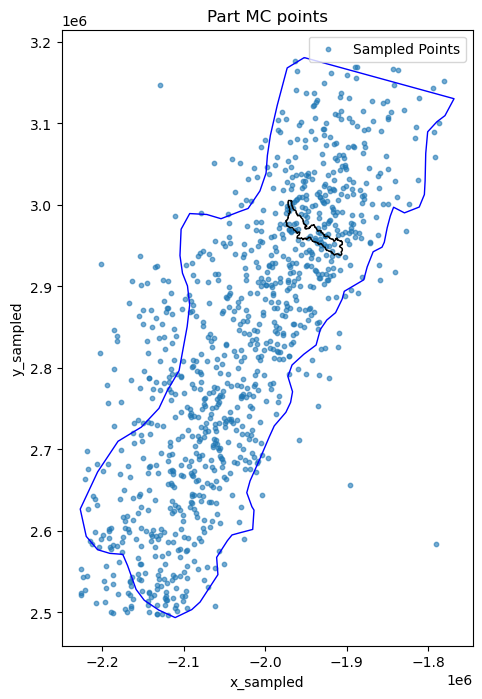

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Part MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

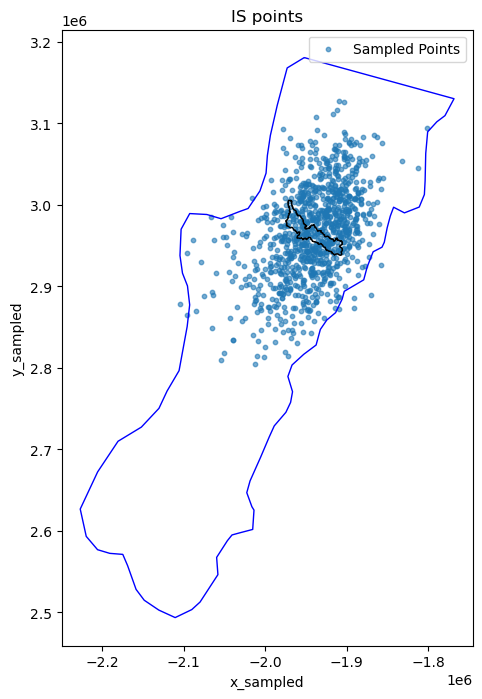

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_is.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

In [21]:
df_part_is

,name,path,x,y,x_sampled,y_sampled,weight,prob,x_del,y_del,depth,intersected,prob_exceed,return_period
0,20071202_T003,/workspaces/Importance-Sampling-for-SST/data/0...,-1.976766e+06,2.922578e+06,-1.929030e+06,2.940671e+06,0.101112,0.037077,47735.325677,18092.421614,312.695160,1,0.000999,1001.000000
1,20061105_T002,/workspaces/Importance-Sampling-for-SST/data/0...,-1.996010e+06,2.875320e+06,-1.940377e+06,2.961314e+06,0.092814,0.015096,55633.039616,85994.642345,302.311920,1,0.001998,500.500000
2,20071202_T003,/workspaces/Importance-Sampling-for-SST/data/0...,-1.976766e+06,2.922578e+06,-1.941492e+06,2.983919e+06,0.095966,0.057496,35273.987874,61340.248985,286.351257,1,0.002997,333.666667
3,20071202_T003,/workspaces/Importance-Sampling-for-SST/data/0...,-1.976766e+06,2.922578e+06,-1.911002e+06,2.950032e+06,0.105337,0.014590,65763.652109,27454.000434,285.469971,1,0.003996,250.250000
4,20061105_T002,/workspaces/Importance-Sampling-for-SST/data/0...,-1.996010e+06,2.875320e+06,-1.941220e+06,2.945347e+06,0.096979,0.014986,54790.300012,70027.188410,277.848785,1,0.004995,200.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20061110_T182,/workspaces/Importance-Sampling-for-SST/data/0...,-1.984204e+06,2.897097e+06,-2.039765e+06,2.966443e+06,0.247697,0.394680,-55561.192590,69346.087026,22.613750,1,0.995005,1.005020
996,19820122_T033,/workspaces/Importance-Sampling-for-SST/data/0...,-1.981581e+06,2.894450e+06,-2.023237e+06,2.961828e+06,0.182806,0.036273,-41656.043769,67378.048656,21.078484,1,0.996004,1.004012
997,20091215_T124,/workspaces/Importance-Sampling-for-SST/data/0...,-2.020148e+06,2.821774e+06,-1.870010e+06,2.889640e+06,0.302128,0.291760,150137.748795,67866.228680,13.998529,1,0.997003,1.003006
998,20130522_T403,/workspaces/Importance-Sampling-for-SST/data/0...,-2.023456e+06,2.822280e+06,-2.023536e+06,2.901343e+06,0.290337,0.136962,-79.918915,79062.921734,7.402702,1,0.998002,1.002002
